In [10]:
from typing import Tuple, List
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [11]:
class Point():
    def __init__(self, x: float, y: float) -> 'Point':
        self.x = x
        self.y = y
    
    def __eq__(self, other) -> bool:
        return (self.x == other.x and self.y == other.y)
    
    def __str__(self) -> str:
        return "{}, {}".format(self.x, self.y)
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def follows(self, other: 'Point') -> bool:
        return self.x > other.x and self.y > other.y
    
    def precedes(self, other: 'Point') -> bool:
        return self.x < other.x and self.y < other.y

In [6]:
class Rect():
    def __init__(self, lower_left: Tuple[float, float], upper_right: Tuple[float, float]) -> 'Rect':
        self.lower_left = Point(*lower_left)
        self.upper_right = Point(*upper_right) 
        
        if not self.lower_left.precedes(self.upper_right):
            raise ValueError('Lower-left point must precede the upper-right')
    
    def __eq__(self, other: 'Rect') -> bool:
        return self.lower_left == other.lower_left and self.upper_right == other.upper_right
    
    def __str__(self) -> str:
        return "{} - {}".format(self.lower_left, self.upper_right)
    
    def __repr__(self):
        return self.__str__()
    
    def intersects(self, other: 'Rect') -> bool:
        return self.lower_left.precedes(other.upper_right) and other.lower_left.precedes(self.upper_right)
    
    def contains_point(self, point: Point) -> bool: # Type of point is left intentionally ambiguous
        return self.lower_left.precedes(point) and self.upper_right.follows(point)
    
    def contains_rectangle(self, rect: 'Rect') -> bool:
        return self.lower_left.precedes(rect.lower_left) and self.upper_right.follows(rect.upper_right)

    def divide_vertically(self) -> Tuple['Rect', 'Rect']:
        midpoint = (self.lower_left.x + self.upper_right.x) / 2
        left = Rect((self.lower_left.x, self.lower_left.y), (midpoint, self.upper_right.y))
        right = Rect((midpoint, self.lower_left.y), (self.upper_right.x, self.upper_right.y))
        return left, right

    def divide_horizontally(self) -> Tuple['Rect', 'Rect']:
        midpoint = ((self.lower_left.y + self.upper_right.y) / 2)
        up = Rect((self.lower_left.x, midpoint), (self.upper_right.x, self.upper_right.y))
        down = Rect((self.lower_left.x, self.lower_left.y), (self.upper_right.x, midpoint))
        return up, down

In [7]:
class QuadTree():
    CAPACITY = 1 # Arbitrary constant to indicate how many elements can be stored in this quad tree node
    
    def __init__(self, bounding_box: Rect) -> 'QuadTree':
        self.bounding_box = bounding_box
        self.points: List[Point] = []
        
        self.upper_right: QuadTree = None
        self.upper_left: QuadTree = None
        self.lower_right: QuadTree = None
        self.lower_left: QuadTree = None
            
    def insert(self, point: Point):
        if not self.bounding_box.contains_point(point):
            return False
        if len(self.points) < QuadTree.CAPACITY and self.upper_right == None:
            self.points.append(point)
            return True
        if self.upper_right == None:
            self._subdivide()
        
        if self.upper_right.insert(point):
            return True
        if self.upper_left.insert(point):
            return True
        if self.lower_right.insert(point):
            return  True
        if self.lower_left.insert(point):
            return True
            
        raise RuntimeError("Failed when inserting {}".format(point))
    
    def querry_range(self, rect: Rect) -> List[Point]:
        if not rect.intersects(self.bounding_box):
            return []
        
        result: List[Point] = list(filter(lambda point: rect.contains_point(point), self.points))
        if self.upper_right == None:
            return result
        
        result.extend(self.upper_right.querry_range(rect))
        result.extend(self.upper_left.querry_range(rect))
        result.extend(self.lower_right.querry_range(rect))
        result.extend(self.lower_left.querry_range(rect))
        return result
            
    
    def _subdivide(self):
        left, right = self.bounding_box.divide_vertically()
        up_left, down_left = left.divide_horizontally()
        up_right, down_right = right.divide_horizontally()
        
        self.upper_right = QuadTree(up_right)
        self.upper_left = QuadTree(up_left)
        self.lower_right = QuadTree(down_right)
        self.lower_left = QuadTree(down_left)


In [14]:
def visualise(ax, tree: QuadTree):
    for point in tree.points:
        ax.plot(point.x, point.y, 'ro')
        
    if tree.upper_right == None:
        width = tree.bounding_box.upper_right.x - tree.bounding_box.lower_left.x
        height = tree.bounding_box.upper_right.y - tree.bounding_box.lower_left.y
        ax.add_patch(Rectangle((tree.bounding_box.lower_left.x, tree.bounding_box.lower_left.y), width, height, fill=False))
        return
    
    visualise(ax, tree.upper_right)
    visualise(ax, tree.upper_left)    
    visualise(ax, tree.lower_left)    
    visualise(ax, tree.lower_right)

Found 3 point in range 0.15, 0.15 - 0.8, 0.8


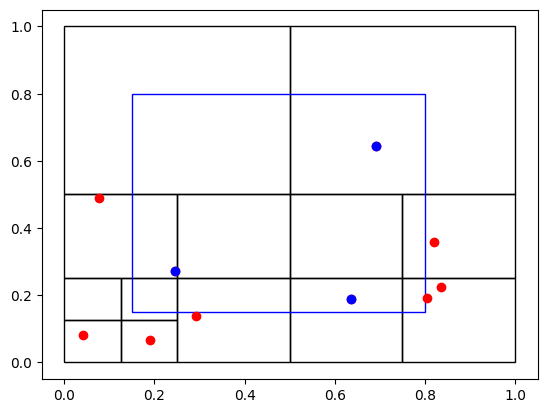

In [15]:
fig, ax = plt.subplots()
tree = QuadTree(Rect((0, 0), (1, 1)))
import random
points = [Point(random.uniform(0, 1), random.uniform(0, 1)) for _ in range(10)]
for p in points:
    tree.insert(p)
visualise(ax, tree)

rect = Rect((0.15, 0.15), (0.8, 0.8))
width = rect.upper_right.x - rect.lower_left.x
height = rect.upper_right.y - rect.lower_left.y
ax.add_patch(Rectangle((rect.lower_left.x, rect.lower_left.y), width, height, fill=False, color='blue'))
found = tree.querry_range(rect)
print("Found {} point in range {}".format(len(found), rect))
for point in found:
    ax.plot(point.x, point.y, marker='o', color='blue')